## Piotr Karaś

# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

In [75]:
from typing import Callable

import numpy as np
from matplotlib import pyplot

In [76]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [77]:
psi_0 = Psi_0()
nx = 64
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 2
t_max = 50

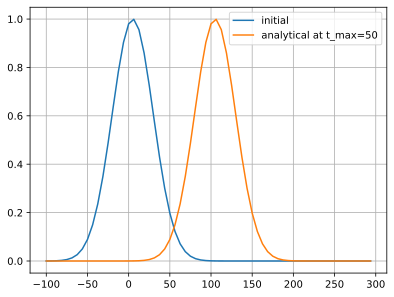

In [78]:
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [79]:
class One:
    def __radd__(self, other: slice) -> slice:
        new = slice(other.start + 1, other.stop + 1, other.step)
        return new

    def __rsub__(self, other: slice) -> slice:
        new = slice(other.start - 1, other.stop - 1, other.step)
        return new

In [80]:
def F(psi_L, psi_R, C):
    """C is Courant number"""
    positive_c_case = (C + np.abs(C)) * .5 * psi_L
    negative_c_case = (C - np.abs(C)) * .5 * psi_R
    return positive_c_case + negative_c_case

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [81]:
nt = 17
dt = t_max / nt
C = u * dt / dx

one = One()
i = slice(1, nx - 2)
psi = psi_0(x)

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [82]:
for _ in range(nt):
    psi[i] = psi[i] - (F(psi[i], psi[i + one], C) - F(psi[i - one], psi[i], C))

**7. comparing analytic and numerical solutions**

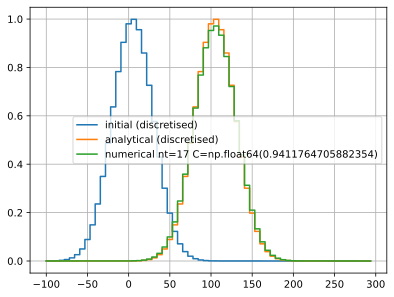

In [83]:
pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
pyplot.legend()
pyplot.grid()

# Analysis Approach and Goals

The objective of this analysis is to evaluate the accuracy of a numerical solution to the one-dimensional advection equation using an upwind finite difference scheme. The approach focuses on measuring the error between the numerical and analytical solutions through the computation of the root mean square error (RMSE).

The analysis is conducted in two parts:
- **Temporal Convergence:** By varying the time step (`dt`) while adjusting the spatial discretization accordingly, we assess how the numerical solution converges in time.
- **Spatial Convergence:** By varying the spatial step (`dx`) and determining the corresponding time step, we examine the convergence behavior in space.

For each case, the numerical solution is obtained via iterative updates using the upwind scheme, and the RMSE is computed to quantify the deviation from the exact solution. The overarching goal is to demonstrate that larger values of `dt` and `dx` lead to increased RMSE, thereby illustrating the trade-off between discretization resolution and numerical accuracy.


In [85]:
def rmse(pred: np.ndarray, correct: np.ndarray) -> float:
    return np.sqrt(np.mean((pred - correct) ** 2))

In [86]:
def create_cases_from_dt(c_, u_, t_max_, dt_) -> tuple[int, np.ndarray, int]:
    nt_ = int(t_max_ / dt_)
    dx_ = u_ * dt_ / c_

    nx_ = int(400 / dx_)
    x_, dx_ = np.linspace(-100, 300, nx_, endpoint=False, retstep=True)

    return nx_, x_, nt_

In [87]:
def create_cases_from_dx(c_, u_, t_max_, dx_) -> tuple[int, np.ndarray, int]:
    dt_ = c_ * dx_ / u_
    nt_ = int(t_max_ / dt_)

    nx_ = int(400 / dx_)
    x_, dx_ = np.linspace(-100, 300, nx_, endpoint=False, retstep=True)

    return nx_, x_, nt_

In [88]:
def advection_upwind(nx_, x_, nt_: int, c_) -> np.ndarray:
    one_ = One()
    i_ = slice(1, nx_ - 2)
    psi_ = psi_0(x_)

    for _ in range(nt_):
        psi_[i_] = psi_[i_] - (F(psi_[i_], psi_[i_ + one_], c_) - F(psi_[i_ - one_], psi_[i_], c_))

    return psi_

In [89]:
def get_errors(c_, u_, t_max_, dt_cases_: np.ndarray, cases_generator: Callable) -> np.ndarray:
    errors_ = np.zeros(len(dt_cases_))
    for idx, dt_ in enumerate(dt_cases_):
        nx_, x_, nt_ = cases_generator(c_, u_, t_max_, dt_)
        solution = advection_upwind(nx_, x_, nt_, c_)
        analytical_solution = psi_0(x_ - u_ * t_max_)
        errors_[idx] = rmse(solution, analytical_solution)

    return errors_

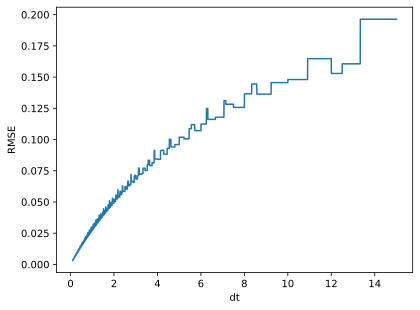

In [94]:
from open_atmos_jupyter_utils import show_plot
from matplotlib import pyplot as plt


c = 0.6
u = 2
t_max = 50

dt_cases = np.linspace(0.1, 15, 10_000)
errors = get_errors(c, u, t_max, dt_cases, cases_generator=create_cases_from_dt)

plt.plot(dt_cases, errors)
plt.xlabel('dt')
plt.ylabel('RMSE')
show_plot()

Text(0, 0.5, 'RMSE')

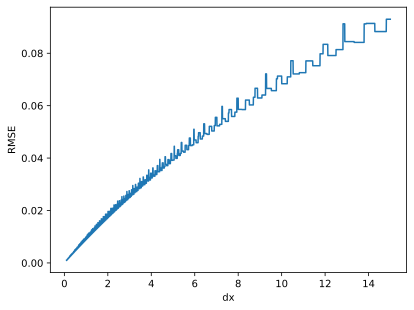

In [97]:
dx_cases = np.linspace(0.1, 15, 10_000)
errors = get_errors(c, u, t_max, dx_cases, cases_generator=create_cases_from_dx)

plt.plot(dx_cases, errors)
plt.xlabel('dx')
plt.ylabel('RMSE')

## Explanation of the Results

The plots illustrate the relationship between discretization steps and the accuracy of the numerical solution as measured by the RMSE. As either the temporal step (dt) or the spatial step (dx) increases, the RMSE also rises, indicating that the numerical solution becomes less accurate. This analysis demonstrates that finer discretizations (i.e., smaller dt and dx) yield a more accurate solution, though at the cost of increased computational resources. Conversely, using larger dt and dx values reduces the computational load but leads to higher errors.
